For this project, we are building an audio translator. We are creating an application that can process speech and translate to the desired language. The user can upload an audio file and the output at the end of the program will be the translation of the speech to the desired language. Please note that the audio should be in english.

We are using an audio dataset to train a speech-to-text model from scratch and later translate the text to multiple user choice languages.

The dataset can be found [here](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge).

### Import the libraries

In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")

### Load data

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
# update with your path
train_audio_path = '/content/gdrive/My Drive/colab_notebooks/audio/'

### Visualize the sound waves

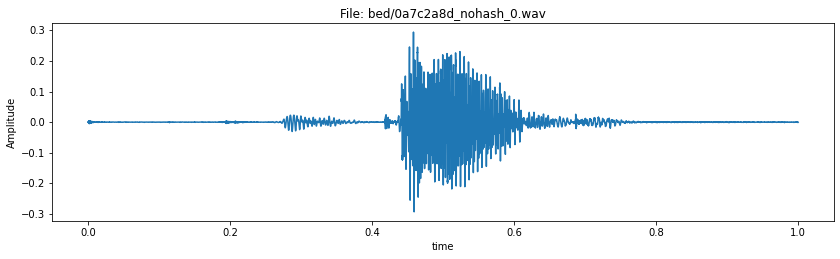

In [4]:
samples, sample_rate = librosa.load(train_audio_path+'bed/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('File: bed/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

Hear the audio

In [5]:
ipd.Audio(samples, rate=sample_rate)

Resample all audio from 16000 hz to 8000 hz (because most of the speech related frequencies are in 8000hz)

In [6]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

We only uploaded a subset of all the data files. Let's visualize the audio labels

In [7]:
labels=os.listdir(train_audio_path)

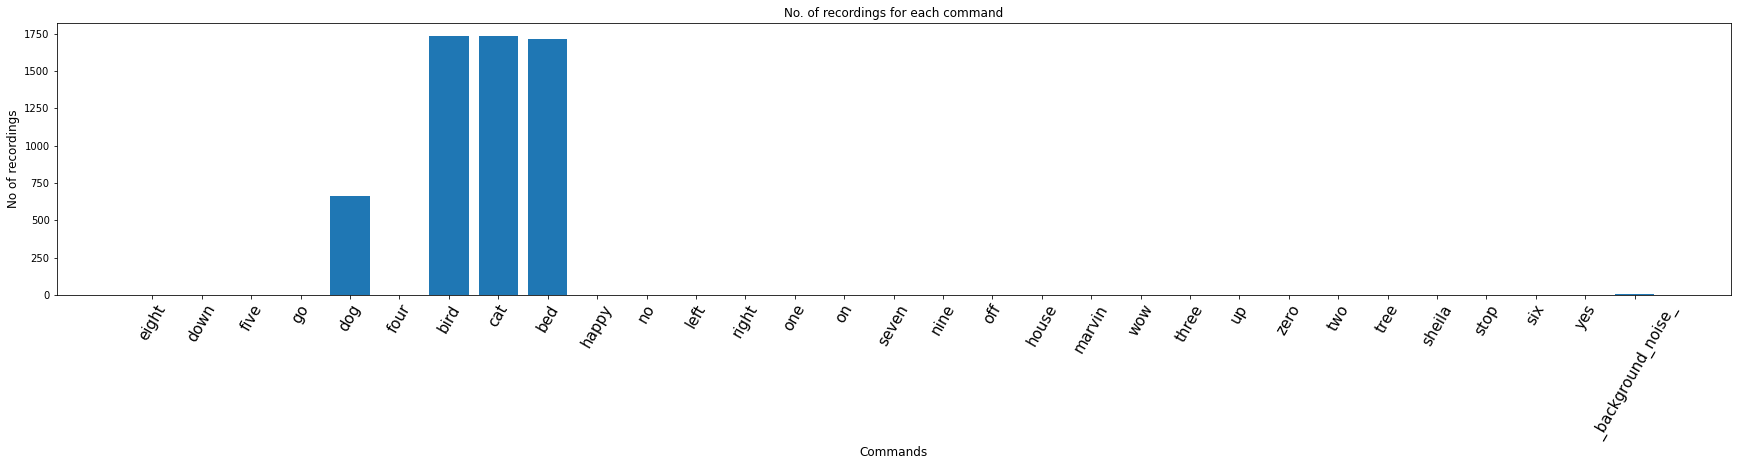

In [8]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [9]:
labels = ["bed", "bird", "cat", "dog"]

Visualize the distribution of audio length

(array([  12.,    9.,   10.,   19.,   72.,   54.,  131.,   94.,  198.,
        5238.]),
 array([0.469375 , 0.5224375, 0.5755   , 0.6285625, 0.681625 , 0.7346875,
        0.78775  , 0.8408125, 0.893875 , 0.9469375, 1.       ]),
 <a list of 10 Patch objects>)

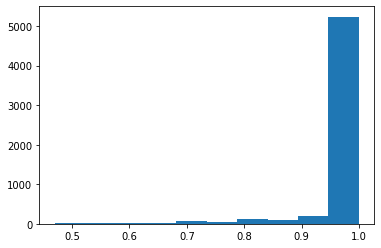

In [10]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

### Preprocessing the data

In [11]:
train_audio_path = '/content/gdrive/My Drive/colab_notebooks/audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

bed
bird
cat
dog


In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [13]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [14]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [15]:
all_wave

array([[[-1.4008731e-03],
        [-3.2715213e-03],
        [-4.4701463e-03],
        ...,
        [ 1.4076607e-03],
        [ 1.2451983e-03],
        [ 2.3868007e-03]],

       [[ 3.7136313e-06],
        [-2.2786684e-05],
        [ 7.1277835e-05],
        ...,
        [ 6.8989240e-05],
        [ 3.1942465e-05],
        [ 9.3023373e-06]],

       [[ 8.2725484e-05],
        [ 1.8732183e-04],
        [ 7.2809480e-06],
        ...,
        [ 2.5072164e-04],
        [ 4.4389672e-04],
        [ 3.2804851e-04]],

       ...,

       [[ 1.7623790e-03],
        [ 2.5706587e-03],
        [ 2.4876425e-03],
        ...,
        [-2.7105759e-03],
        [-2.5555866e-03],
        [-2.6734206e-03]],

       [[-1.0668337e-04],
        [-6.7882624e-04],
        [-8.2726020e-04],
        ...,
        [ 2.8651963e-05],
        [-4.5774974e-07],
        [-7.3034811e-04]],

       [[ 5.7354220e-03],
        [ 1.6284427e-02],
        [-2.0682355e-03],
        ...,
        [-2.7302612e-02],
        [ 2.542

In [16]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave), np.array(y), stratify=y, test_size = 0.2, random_state=777, shuffle=True)

### Build the model

In [17]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

In [18]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Set early stops and checkpoints to save the best model during training and stop training at the right time:

In [19]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [20]:
history = model.fit(x_tr, y_tr ,epochs=30, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/30
128/128 [==============================] - 23s 170ms/step - loss: 1.2633 - accuracy: 0.3907 - val_loss: 1.1211 - val_accuracy: 0.5054
Epoch 2/30
128/128 [==============================] - 21s 168ms/step - loss: 1.0425 - accuracy: 0.5588 - val_loss: 1.0541 - val_accuracy: 0.5593
Epoch 3/30
128/128 [==============================] - 22s 168ms/step - loss: 0.9414 - accuracy: 0.6137 - val_loss: 0.9356 - val_accuracy: 0.6063
Epoch 4/30
128/128 [==============================] - 21s 168ms/step - loss: 0.9031 - accuracy: 0.6271 - val_loss: 0.8287 - val_accuracy: 0.6621
Epoch 5/30
128/128 [==============================] - 22s 169ms/step - loss: 0.8139 - accuracy: 0.6698 - val_loss: 0.8204 - val_accuracy: 0.6787
Epoch 6/30
128/128 [==============================] - 22s 169ms/step - loss: 0.7784 - accuracy: 0.6847 - val_loss: 0.7564 - val_accuracy: 0.6983
Epoch 7/30
128/128 [==============================] - 22s 168ms/step - loss: 0.7332 - accuracy: 0.7082 - val_loss: 0.7137 - val_ac

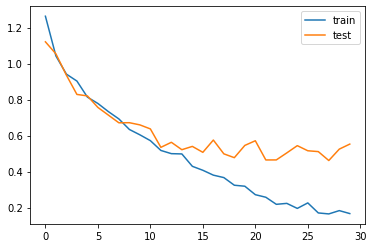

In [21]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Loading the best model

In [22]:
# from keras.models import load_model
# model=load_model('best_model.hdf5')

### Prediction

In [23]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [24]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: bed


In [25]:
pred = predict(samples)
print("Text:", pred)

Text: bed


### Translating the audio text

In [28]:
pip install deep-translator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 128 kB 19.4 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [29]:
from deep_translator import GoogleTranslator

deep_translator supports multiple transaltion engines but for our project we are focussing on using Google Translator.

Some of the languages supported by Google Translator are as below:

In [30]:
g = GoogleTranslator()
langs_list = g.get_supported_languages(as_dict=True)
langs_list

{'afrikaans': 'af',
 'albanian': 'sq',
 'amharic': 'am',
 'arabic': 'ar',
 'armenian': 'hy',
 'azerbaijani': 'az',
 'basque': 'eu',
 'belarusian': 'be',
 'bengali': 'bn',
 'bosnian': 'bs',
 'bulgarian': 'bg',
 'catalan': 'ca',
 'cebuano': 'ceb',
 'chichewa': 'ny',
 'chinese (simplified)': 'zh-CN',
 'chinese (traditional)': 'zh-TW',
 'corsican': 'co',
 'croatian': 'hr',
 'czech': 'cs',
 'danish': 'da',
 'dutch': 'nl',
 'english': 'en',
 'esperanto': 'eo',
 'estonian': 'et',
 'filipino': 'tl',
 'finnish': 'fi',
 'french': 'fr',
 'frisian': 'fy',
 'galician': 'gl',
 'georgian': 'ka',
 'german': 'de',
 'greek': 'el',
 'gujarati': 'gu',
 'haitian creole': 'ht',
 'hausa': 'ha',
 'hawaiian': 'haw',
 'hebrew': 'iw',
 'hindi': 'hi',
 'hmong': 'hmn',
 'hungarian': 'hu',
 'icelandic': 'is',
 'igbo': 'ig',
 'indonesian': 'id',
 'irish': 'ga',
 'italian': 'it',
 'japanese': 'ja',
 'javanese': 'jw',
 'kannada': 'kn',
 'kazakh': 'kk',
 'khmer': 'km',
 'kinyarwanda': 'rw',
 'korean': 'ko',
 'kurdish':

In [31]:
target_lang = ''

while(target_lang!='exit'):
    target_lang = input("\n\nWhich language would you like to translate too? \n(Note: Only language supported by Google translator would be considered. Enter 'exit' to stop.)\n")
    
    if target_lang!='exit':   
        try: 
            # Using google translator from deep translator to translate the audio text
            translated = GoogleTranslator(source='auto', target=target_lang.lower()).translate(predict(samples))
            print(translated)
        except:
            ("Unsupported Language")
            break
    else:
        break          



Which language would you like to translate too? 
(Note: Only language supported by Google translator would be considered. Enter 'exit' to stop.)
french
lit


Which language would you like to translate too? 
(Note: Only language supported by Google translator would be considered. Enter 'exit' to stop.)
german
Bett


Which language would you like to translate too? 
(Note: Only language supported by Google translator would be considered. Enter 'exit' to stop.)
exit


Acknowledgments: Please note the code is modified from the original in this [article](https://www.analyticsvidhya.com/blog/2019/07/learn-build-first-speech-to-text-model-python/). We added the translation.